In [16]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dropout, MaxPooling2D, concatenate
from tensorflow.keras import layers
from tensorflow.keras import models
from skimage.transform import resize
from tensorflow.keras import Input
from tensorflow.keras import Model
import plotly.graph_objects as go
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras.metrics import IoU

In [17]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("franciscoescobar/satellite-images-of-water-bodies")

print("Path to dataset files:", path)

d:\prj\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\shiva\.cache\kagglehub\datasets\franciscoescobar\satellite-images-of-water-bodies\versions\2


In [18]:
image_path = 'Water Bodies Dataset/Images'
mask_path = 'Water Bodies Dataset/Masks'

train_ids = sorted([os.path.join(image_path, path)
                   for path in os.listdir(image_path)
                   if path.endswith('.jpg')])

mask_ids = sorted([os.path.join(mask_path, path)
                  for path in os.listdir(mask_path)
                  if path.endswith('.jpg')])

In [ ]:
def resize_mask(path, size):
    # Convert the mask to grayscale
    mask = cv.imread(path).astype('float32') 
    mask_gray = cv.cvtColor(mask, cv.COLOR_RGB2GRAY)
    # Resize the mask to the specified size
    _, img = cv.threshold(mask_gray, 100, 255, cv.THRESH_BINARY)
    resized_mask = cv.resize(img, size, interpolation=cv.INTER_NEAREST)/ 255
    resized_mask = np.expand_dims(resized_mask, axis=2)
    return resized_mask

def resize_image(path, size):
    img = cv.imread(path).astype('float32') / 255
    img = cv.resize(img, size)
    return img

images = []
labels = []
for image, mask in zip(train_ids, mask_ids):
    img = resize_image(image, (128, 128))
    mask = resize_mask(mask, (128, 128))
    images.append(img)
    labels.append(mask)
    
images_array = np.array(images)
labels_array = np.array(labels)

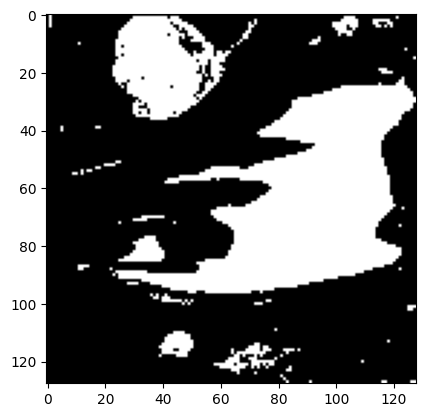

In [ ]:
plt.imshow(labels_array[-5], cmap='gray')

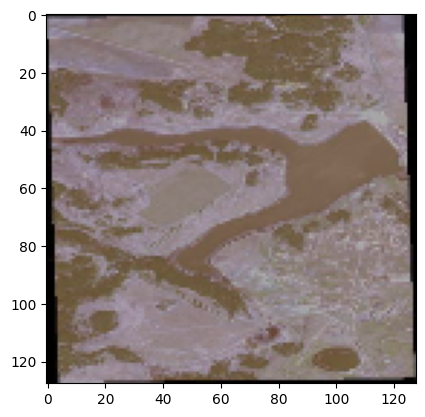

In [6]:
plt.imshow(images_array[-2])

In [7]:
x_train, x_test, y_train, y_test = train_test_split(images_array, labels_array, test_size=0.15)

In [8]:
inputs = keras.Input(shape=(128, 128, 3))
x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

x = Conv2DTranspose(256, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(256, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)

outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [9]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 128, 128, 256)  │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 256)  │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 128, 128, 128)  │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 128, 128, 128)  │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 128, 128, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 128, 128, 64)   │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 128, 128, 32)   │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,933,761 (11.19 MB)

 Trainable params: 2,933,761 (11.19 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [11]:
call_basks = [
    keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    keras.callbacks.ModelCheckpoint('model.keras', save_best_only=True)
]

In [15]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy()])


In [16]:
print(x_train.shape, y_train.shape)

(2414, 128, 128, 3) (2414, 128, 128, 1)


In [15]:
history = model.fit(x_train, y_train, validation_split=0.15, epochs=1, callbacks=call_basks)

NameError: name 'model' is not defined

In [14]:
my_dict = history.history

number_range = [x for x in range(10)]

regress_loss = my_dict['loss']
val_regress_loss = my_dict['val_loss']
fig = go.Figure()
fig.add_trace(go.Scatter(x=number_range, y=regress_loss, mode='lines', name='loss'))
fig.add_trace(go.Scatter(x=number_range, y=val_regress_loss, mode='lines', name='val_loss'))
fig.write_html("plot.html")



NameError: name 'history' is not defined

In [13]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])


NameError: name 'model' is not defined

In [12]:
regress_loss = my_dict['binary_accuracy']
val_regress_loss = my_dict['val_binary_accuracy']

# Ensure the range matches the length of your accuracy lists
number_range = list(range(len(regress_loss)))

fig = go.Figure()
fig.add_trace(go.Scatter(x=number_range, y=regress_loss, mode='lines', name='Binary Accuracy'))
fig.add_trace(go.Scatter(x=number_range, y=val_regress_loss, mode='lines', name='Validation Binary Accuracy'))
fig.write_html("plot.html")


NameError: name 'my_dict' is not defined

In [11]:
print(my_dict.keys())


NameError: name 'my_dict' is not defined

In [10]:
fainal_model = keras.models.load_model('model.keras')
y_pred = fainal_model.predict(x_test)
for i in range(y_pred.shape[0]):
    _, mask = cv.threshold(y_pred[i], 0.2, 1, cv.THRESH_BINARY)
    y_pred[i] = mask.reshape(128, 128, 1)

NameError: name 'x_test' is not defined

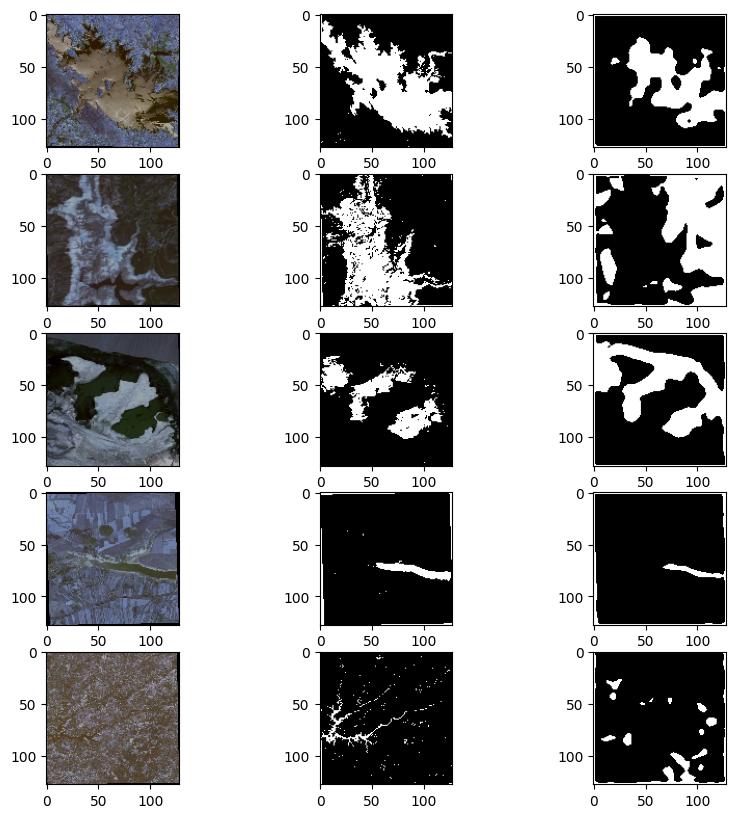

In [47]:
fig, ax = plt.subplots(5, 3, figsize=(10, 10))
for i in range(5):
    num = random.randint(1, 400)
    ax[i,0].imshow(x_test[num])
    ax[i, 1].imshow(y_test[num], cmap='gray')
    ax[i, 2].imshow(y_pred[num], cmap='gray')

In [16]:
metrics = IoU(num_classes=2, target_class_ids=[1])
metrics.update_state(y_test, y_pred)
metrics.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.6270293>

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2 as cv
from tensorflow import keras

# Load the model and make predictions
final_model = keras.models.load_model('model.keras')
y_pred = final_model.predict(x_test)

# Thresholding to create binary masks
for i in range(y_pred.shape[0]):
    _, mask = cv.threshold(y_pred[i], 0.2, 1, cv.THRESH_BINARY)
    y_pred[i] = mask.reshape(128, 128, 1)

# Set up the figure
fig, ax = plt.subplots(5, 3, figsize=(10, 10))

# Define the points to mark on the images (example coordinates)
points = [(30, 40), (60, 80), (100, 120)]  # Replace with your coordinates

for i in range(5):
    num = random.randint(0, 399)  # Make sure to use the correct index range
    ax[i, 0].imshow(x_test[num])
    ax[i, 0].set_title('Input Image')
    ax[i, 1].imshow(y_test[num], cmap='gray')
    ax[i, 1].set_title('True Mask')
    ax[i, 2].imshow(y_pred[num], cmap='gray')
    ax[i, 2].set_title('Predicted Mask')
    
    # Add points to each image
    for point in points:
        ax[i, 0].scatter(point[0], point[1], color='red', s=50)  # Points on input image
        ax[i, 1].scatter(point[0], point[1], color='red', s=50)  # Points on true mask
        ax[i, 2].scatter(point[0], point[1], color='red', s=50)  # Points on predicted mask

# Adjust layout
plt.tight_layout()
plt.show()


NameError: name 'x_test' is not defined